In [1]:
import flopy
import flopy.mf6 as mf6
import flopy.plot as fplt

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

import cartopy
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles

import findwells as fw

After running the simulation, the outputs are saved to the output files directory. Luckily, you don't need to recreate and run the simulation every time you would like to visualize the outputs. 

Simply load in the simulation and grab the model objects, then retrieve the outputs from the model object!

## Load Simulation

In [2]:
# Load Simulation
sim = mf6.MFSimulation.load(sim_name='peterson', exe_name='../../mf6/mf6.exe', sim_ws='../input-files/')

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package riv...
    loading package obs...
    loading package wel...
    loading package chd...
    loading package sto...
    loading package rch...
    loading package oc...
    loading package rch...
  loading model gwt6...
    loading package dis...
    loading package ic...
    loading package adv...
    loading package dsp...
    loading package mst...
    loading package ist...
    loading package ssm...
    loading package obs...
    loading package oc...
  loading model gwt6...
    loading package dis...
    loading package ic...
    loading package adv...
    loading package dsp...
    loading package ist...
    loading package mst...
    loading package ssm...
    loading package obs...
    loading package oc...
  loading model gwt6...
    loading package dis...
    loading packag

## Load Models

In [3]:
# Grab groundwater flow model from simulation
gwf = sim.get_model('peterson_flow')

# Grab transport model for each solute
gwt_pfos = sim.get_model('peterson_pfos')
gwt_pfoa = sim.get_model('peterson_pfoa')
gwt_pfhxs = sim.get_model('peterson_pfhxs')

## Visualizing Head Data

In [4]:
# read head outputs from model object
head_obj = gwf.output.head()

# Load data from final timestep
heads = head_obj.get_data()

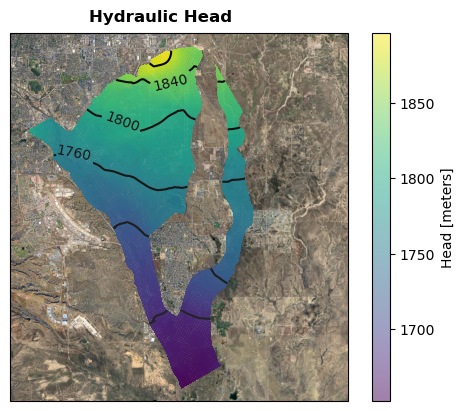

In [5]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained', figsize=(6,4), )#dpi=300)

modelmap = fplt.PlotMapView(model=gwf)

vmax = heads[heads!=1e30].max()
vmin = heads[heads!=1e30].min()
cellhead = modelmap.plot_array(heads[0], ax=ax, cmap='viridis', 
                               transform=ccrs.UTM(13), alpha=0.5)
fig.colorbar(cellhead, ax=ax, label='Head [meters]')

contour = modelmap.contour_array(heads[0], ax=ax, vmin=0,
                                 transform=ccrs.UTM(13), cmap='Grays')

ggtiles = GoogleTiles(style='satellite')
ax.add_image(ggtiles, 13)
ax.set_xlabel('Easting [meters]')
ax.set_ylabel('Northing [meters]')
ax.clabel(contour)

plt.suptitle('Hydraulic Head', weight='bold')
plt.show()

## Plot Flooded Cells

In [6]:
# Load in top elevation of layer
top_elev = np.loadtxt('../input-files/data-files/dis-top-elev.dat')

# Take difference between top elevation and head
diff = top_elev - heads[0]
diff_neg = np.where(diff < 0, diff, np.nan)  # Grab negative values (head > top)

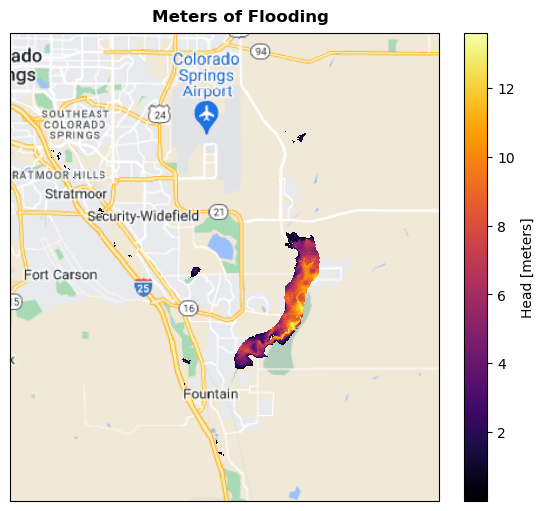

In [7]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained', figsize=(6,5))#, dpi=300)

modelmap = fplt.PlotMapView(model=gwf)

cellhead = modelmap.plot_array(-diff_neg, ax=ax, cmap='inferno', transform=ccrs.UTM(13))
fig.colorbar(cellhead, ax=ax, label='Head [meters]')

ggtiles = GoogleTiles()
ax.add_image(ggtiles, 11)
ax.set_xlabel('Easting [meters]')
ax.set_ylabel('Northing [meters]')

plt.suptitle('Meters of Flooding', weight='bold')
# plt.savefig('../figures/flooded-cells.png', bbox_inches='tight')
plt.show()

## Plot Observed vs Simulated Heads

In [8]:
# Read in simulated observations to a dataframe
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/head_obs.csv', isBinary=False)
sim_df = obs_out.get_dataframe()

In [9]:
# Set time index
sim_df.set_index('totim', inplace=True)
sim_df.head()

# Remove duplicate columns by keeping the first occurrence
sim_df = sim_df.loc[:, ~sim_df.columns.duplicated()]
sim_df.head()

FOUNTAIN NO.1  SC01406518ACD T02-MW006  SC01406518CAA MW 1-1  \
totim                                                                 
59.0     1682.008938              1885.455707           1880.476784   
89.0     1681.974905              1885.462255           1880.499818   
274.0    1681.873247              1885.508854           1880.638585   
304.0    1681.815335              1885.505131           1880.617374   
365.0    1681.780126              1885.510489           1880.600005   

       SC01406519ABD T04-MW004  SC01406519BBB T01-MW002  SC01406520CDB MW2-4  \
totim                                                                          
59.0               1846.441150              1867.342818          1820.508540   
89.0               1846.617592              1867.418896          1820.666800   
274.0              1847.974243              1867.743335          1823.289603   
304.0              1847.998486              1867.676975          1823.745726   
365.0              1848.736070              1867.586417          1826.001585   

       SC01406527ACB1  SC01406527DDB1 BANNING-LEWIS RANCHES  SC01406527DDB2  \
totim                                                                         
59.0      1819.618737                           1811.985088     1809.927554   
89.0      1819.803424                           1812.116151     1810.104955   
274.0     1819.821606                           1812.459523     1810.563878   
304.0     1819.825250                           1812.494202     1810.620196   
365.0     1819.829021                           1812.577400     1810.728309   

       SC01406527DDC1  ...  SCO1506602BBB TH-18  SCO1506602BDC  SCO1506602CAA  \
totim                  ...                                                      
59.0      1807.807384  ...          1774.684131    1766.093697    1764.109938   
89.0      1807.958309  ...          1774.669078    1766.102305    1764.116961   
274.0     1808.437779  ...          1773.904142    1765.801899    1764.144266   
304.0     1808.503853  ...          1773.823395    1765.757825    1764.146199   
365.0     1808.626432  ...          1773.396564    1765.551692    1764.126777   

       SCO1506603AAD  SCO1506603BAC  SCO1506604AAA  SCO1506604AAB TH-49  \
totim                                                                     
59.0     1768.602674    1761.823488    1763.989972          1762.171530   
89.0     1768.600017    1761.804051    1763.760061          1762.476564   
274.0    1768.069533    1761.448278    1763.336524          1762.390345   
304.0    1768.007516    1761.393172    1763.287701          1762.378165   
365.0    1767.656459    1761.256686    1763.174787          1762.351467   

       SCO1506604ABA2 TH-50  SCO1506610BAA  SCO1506611ABC TH-47  
totim                                                            
59.0            1762.211240    1749.539323          1748.027540  
89.0            1762.556356    1749.539900          1748.027649  
274.0           1762.499652    1749.534359          1748.045605  
304.0           1762.491362    1749.531093          1748.048874  
365.0           1762.473243    1749.521342          1748.056918  

[5 rows x 149 columns]

In [10]:
obs_df = pd.read_csv('../input-files/data-files/flow-observed-heads.csv', index_col='time')
obs_df.head()

FOUNTAIN NO.1  SC01406518ACD T02-MW006  SC01406518CAA MW 1-1  \
time                                                                 
59              NaN                      NaN                   NaN   
89              NaN                      NaN                   NaN   
454             NaN                      NaN                   NaN   
639             NaN                      NaN                   NaN   
789             NaN                      NaN                   NaN   

      SC01406519ABD T04-MW004  SC01406519BBB T01-MW002  SC01406520CDB MW2-4  \
time                                                                          
59                        NaN                      NaN                  NaN   
89                        NaN                      NaN                  NaN   
454                       NaN                      NaN                  NaN   
639                       NaN                      NaN                  NaN   
789                       NaN                      NaN                  NaN   

      SC01406527ACB1  SC01406527DDB1 BANNING-LEWIS RANCHES  SC01406527DDB2  \
time                                                                         
59               NaN                                   NaN             NaN   
89               NaN                                   NaN             NaN   
454              NaN                                   NaN             NaN   
639              NaN                                   NaN             NaN   
789              NaN                                   NaN     1802.757888   

      SC01406527DDC1  ...  SCO1506602BBB TH-18  SCO1506602BDC  SCO1506602CAA  \
time                  ...                                                      
59               NaN  ...                  NaN            NaN            NaN   
89               NaN  ...                  NaN            NaN            NaN   
454              NaN  ...                  NaN            NaN            NaN   
639              NaN  ...                  NaN            NaN            NaN   
789      1803.123648  ...                  NaN            NaN            NaN   

      SCO1506603AAD  SCO1506603BAC  SCO1506604AAA  SCO1506604AAB TH-49  \
time                                                                     
59              NaN            NaN            NaN                  NaN   
89              NaN            NaN            NaN                  NaN   
454             NaN            NaN            NaN                  NaN   
639             NaN            NaN            NaN                  NaN   
789             NaN            NaN            NaN                  NaN   

      SCO1506604ABA2 TH-50  SCO1506610BAA  SCO1506611ABC TH-47  
time                                                            
59                     NaN            NaN                  NaN  
89                     NaN            NaN                  NaN  
454                    NaN            NaN                  NaN  
639                    NaN            NaN                  NaN  
789                    NaN            NaN                  NaN  

[5 rows x 149 columns]

In [11]:
# Align sim_df and obs_df by their common indices
common_index = sim_df.index.intersection(obs_df.index)

# Use only the rows corresponding to the common index
sim_df_aligned = sim_df.loc[common_index]
obs_df_aligned = obs_df.loc[common_index]

Well SC01506614BBA TH-5 not in both


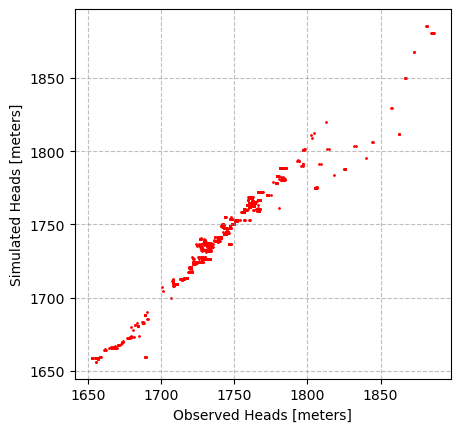

In [12]:
fig, ax = plt.subplots()

for col in sim_df.columns:
    if (col != 'SC01506614BBA TH-5') & (col != 'SC01606516CCC2'):
        ax.scatter(obs_df_aligned[col], sim_df_aligned[col], color='r', s=1)

    else:
        print(f"Well {col} not in both")

ax.set_xlabel('Observed Heads [meters]')
ax.set_ylabel('Simulated Heads [meters]')
ax.set_aspect('equal')
ax.grid(ls='--', color='gray', alpha=0.5)

## Plot Concentration Results

### PFOS Results

In [13]:
# Get solute concentrations
PFOS = gwt_pfos.output.concentration().get_alldata()
# PFOA = gwt_pfoa.output.concentration().get_alldata()
# PFHxS = gwt_pfhxs.output.concentration().get_alldata()

In [14]:
PFOS.shape,# PFOA.shape, PFHxS.shape

((446, 1, 972, 700),)

In [15]:
pfos = gwt_pfos.output.concentration().get_data()

In [16]:
downstream_wells = pd.read_csv('../input-files/data-files/tran-targets-downstream.csv')
upstream_well = pd.read_excel('../input-files/data-files/tran-PFAS-targets.xlsx', sheet_name='PFOS')

In [17]:
from matplotlib.colors import LogNorm

In [18]:
x = gwt_pfos.modelgrid.xcellcenters[downstream_wells['x'], downstream_wells['y']]
y = gwt_pfos.modelgrid.ycellcenters[downstream_wells['x'], downstream_wells['y']]

In [19]:
k = np.loadtxt('../input-files/data-files/flow-kfield.dat')

In [20]:
#upstream_well[upstream_well['Result_ngL'] == 0]

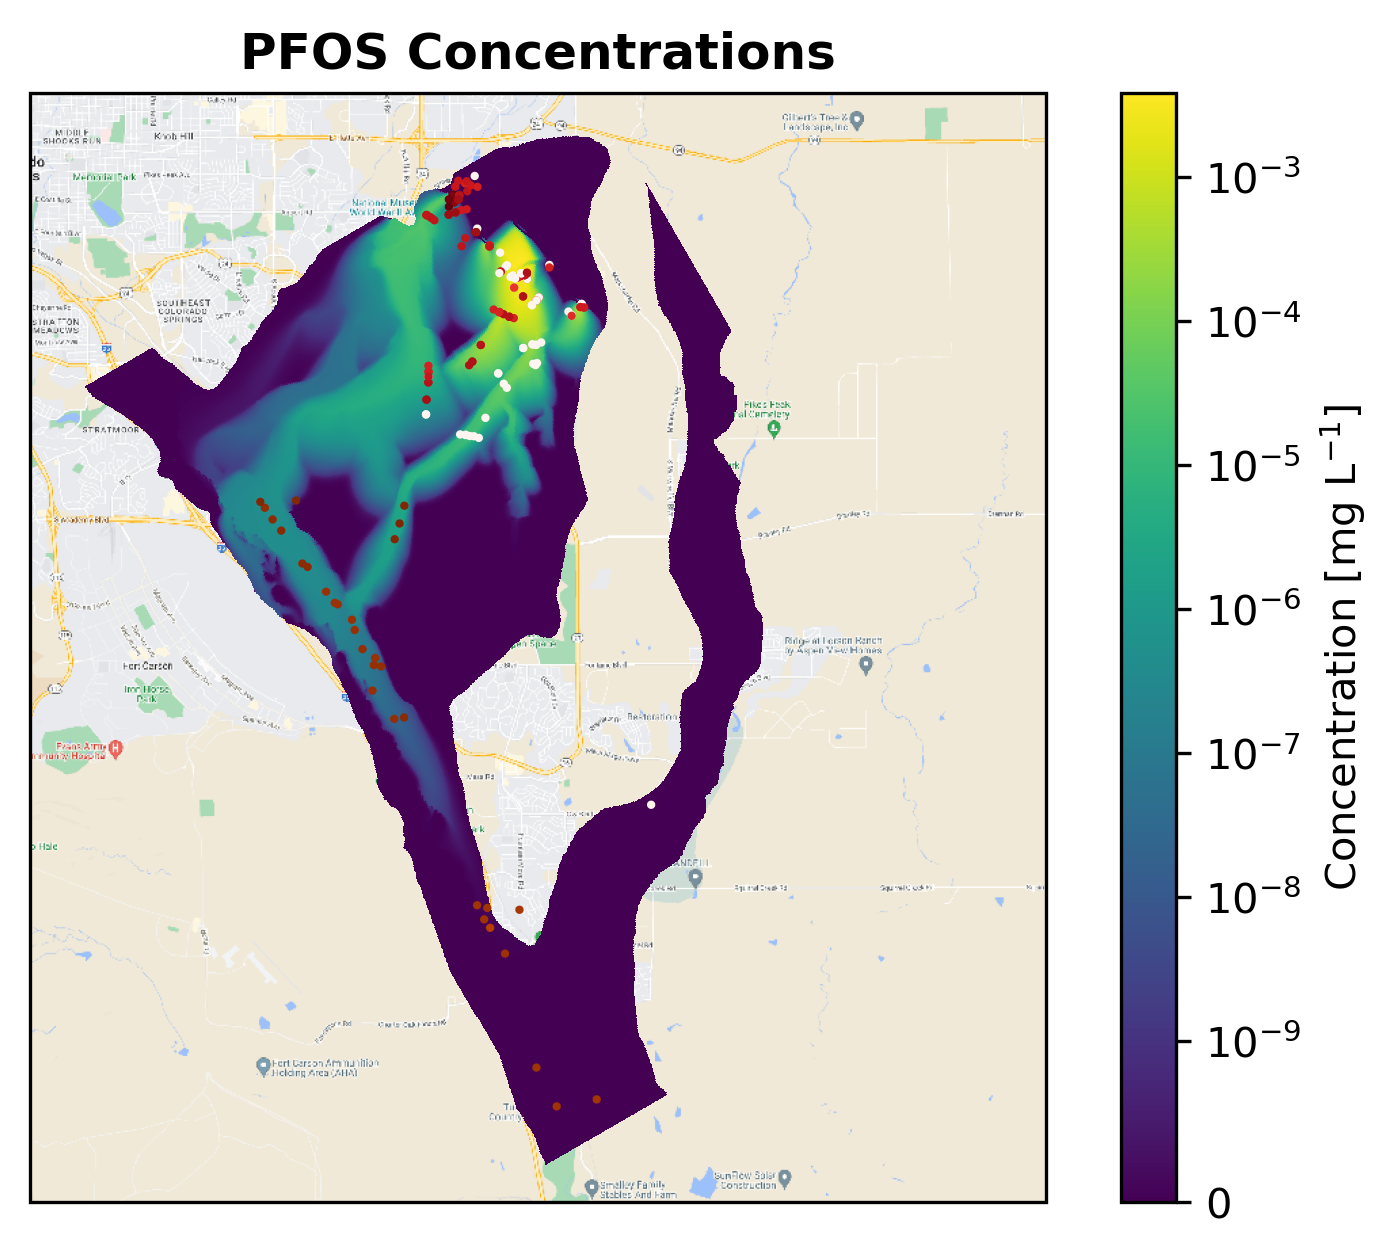

In [21]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, dpi=300)

modelmap = fplt.PlotMapView(model=gwt_pfos)

vmax = pfos[pfos != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
cs1 = modelmap.plot_array(pfos, transform=ccrs.UTM(13), norm=norm)
fig.colorbar(cs1, ax=ax, label="Concentration [mg L$^{-1}$]")

# cs1 = modelmap.plot_array(k, transform=ccrs.UTM(13))
# fig.colorbar(cs1, ax=ax, label="Concentration [mg L$^{-1}$]")

ax.scatter(upstream_well['x'], upstream_well['y'], label=upstream_well['Well_ID'], transform=ccrs.PlateCarree(), c=upstream_well['Result_ngL'], s=1, cmap='Reds', norm=SymLogNorm(linthresh=1e-9, vmin=0))

ax.scatter(x, y, c=downstream_wells['PFOS (ng/L)'], transform=ccrs.UTM(13), cmap='Oranges', norm=SymLogNorm(linthresh=1e-9, vmin=0), s=1)


ggtiles = GoogleTiles()
ax.add_image(ggtiles, 13)
ax.set_title('PFOS Concentrations', weight='bold')

plt.show()

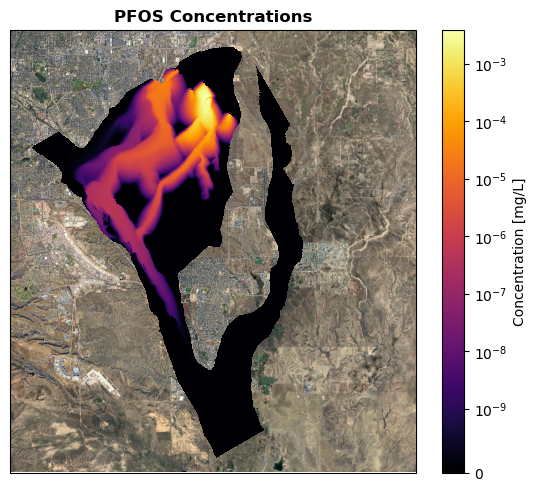

In [22]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained',)# figsize=(18, 5))

modelmap = fplt.PlotMapView(model=gwt_pfos)

# plot PFOS
vmax = PFOS[PFOS != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
conc = modelmap.plot_array(PFOS[-1], ax=ax, cmap='inferno', norm=norm,
                               transform=ccrs.UTM(13))
fig.colorbar(conc, ax=ax, label='Concentration [mg/L]')

ggtiles = GoogleTiles(style='satellite')
ax.add_image(ggtiles, 13)
ax.set_title('PFOS Concentrations', weight='bold')

plt.show()

### Observed vs Simulated PFOS concentration

Day of sampling since model start: `17713`

In [23]:
# Read in simulated observations to a dataframe
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/pfos_obs.csv', isBinary=False)
sim_wells = obs_out.get_dataframe()

closest_index = sim_wells.index[(np.abs(sim_wells.totim - 17713)).argmin()]
sim_results = sim_wells.loc[closest_index]

In [24]:
obs_wells = pd.read_csv('../input-files/data-files/tran-targets-downstream.csv', index_col='Well Name')
obs_wells = obs_wells.T

In [25]:
common_index = obs_wells.columns.intersection(sim_results.index)

sim_results = sim_results.loc[common_index] * 1e6
obs_results = obs_wells.T.loc[common_index, "PFOS (ng/L)"]

Text(0, 0.5, 'Simulated Concentration [ng L$^{-1}$]')

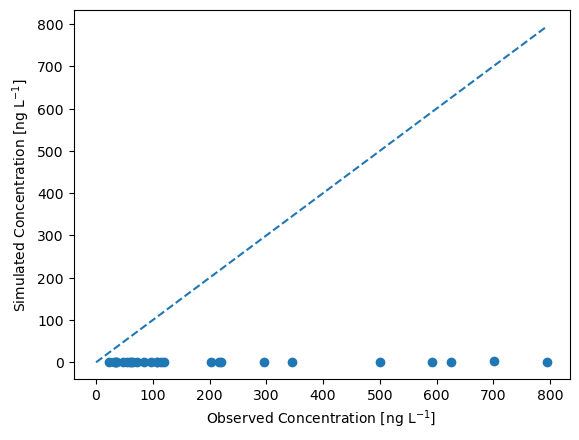

In [26]:
obs = obs_results.to_numpy(dtype='float64')
sim = sim_results.to_numpy(dtype='float64')

vmin = min(obs.min(), sim.min())
vmax = max(obs.max(), sim.max())
xy = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots()

ax.scatter(obs, sim)
ax.plot(xy, xy, linestyle='--')

ax.set_xlabel('Observed Concentration [ng L$^{-1}$]')
ax.set_ylabel('Simulated Concentration [ng L$^{-1}$]')

In [27]:
pfos_us = pd.read_csv('../input-files/data-files/tran-PFOS-observations.csv')

In [28]:
pfos_us['SDate'] = pd.to_datetime(pfos_us.SDate)

In [29]:
pfos_us.set_index('SDate', inplace=True)

In [30]:
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/pfos_obs.csv', isBinary=False)
sim_wells = obs_out.get_dataframe()

In [31]:
# closest_index = sim_wells.index[(np.abs(sim_wells.totim - 17713)).argmin()]

closest_rows = []
for date in pfos_us.index:
    # Find the closest index in the reshaped DataFrame
    closest_index = sim_wells.index[(np.abs(sim_wells.index - date)).argmin()]
    
    # Store the closest date and row values
    closest_rows.append(closest_index)

In [32]:
sim_wells_aligned = sim_wells.loc[closest_rows]
sim_wells_aligned.drop(columns='totim', axis=1, inplace=True)

Well BRD_6 not in both
Well 11960_OPR_2 not in both
Well 12425_OPR_1 not in both
Well DLE not in both
Well GLD_3 not in both
Well ING_2 not in both
Well IRIS_3 not in both
Well WELL 1 not in both
Well WELL 3 not in both
Well WELL 4 not in both
Well FV4 not in both
Well R1 not in both
Well R2 not in both
Well S2 not in both
Well S4 not in both
Well S7 not in both
Well S9 not in both
Well S10 not in both
Well S11 not in both
Well S12 not in both
Well S13 not in both
Well S14 not in both
Well S15 not in both
Well S16 not in both
Well S17 not in both
Well W8 not in both
Well W9 not in both
Well W12 not in both
Well C2 not in both
Well C36 not in both
Well W7 not in both
Well DEICEPONDSNORTH not in both
Well DEICEPONDSSOUTH not in both


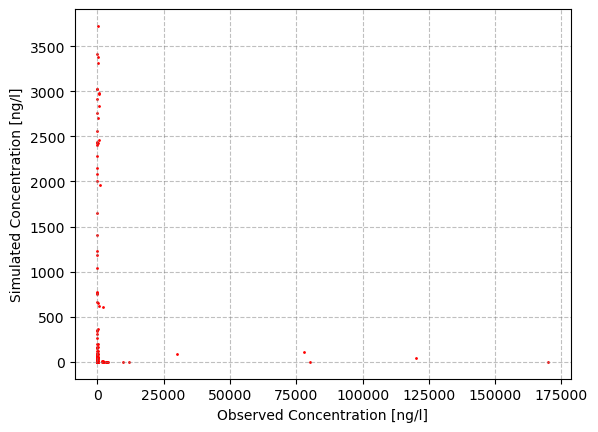

In [33]:
fig, ax = plt.subplots()

for col in sim_wells_aligned.columns:
    try:
        ax.scatter(pfos_us[col], sim_wells_aligned[col] * 1e6, color='r', s=1)

    except:
        print(f"Well {col} not in both")

#ax.set_xscale('log')  # Log scale for the x-axis

ax.set_xlabel('Observed Concentration [ng/l]')
ax.set_ylabel('Simulated Concentration [ng/l]')
# ax.set_aspect('equal')
ax.grid(ls='--', color='gray', alpha=0.5)

### PFOA Results

In [34]:
# Get solute concentrations
PFOA = gwt_pfoa.output.concentration().get_alldata()
# PFHxS = gwt_pfhxs.output.concentration().get_alldata()

In [35]:
PFOA.shape

(446, 1, 972, 700)

In [36]:
pfoa = gwt_pfoa.output.concentration().get_data()

In [37]:
downstream_wells = pd.read_csv('../input-files/data-files/tran-targets-downstream.csv')
upstream_well = pd.read_excel('../input-files/data-files/tran-PFAS-targets.xlsx', sheet_name='PFOA')

In [38]:
from matplotlib.colors import LogNorm

In [39]:
x = gwt_pfos.modelgrid.xcellcenters[downstream_wells['x'], downstream_wells['y']]
y = gwt_pfos.modelgrid.ycellcenters[downstream_wells['x'], downstream_wells['y']]

In [40]:
k = np.loadtxt('../input-files/data-files/flow-kfield.dat')

In [41]:
#upstream_well[upstream_well['Result_ngL'] == 0]

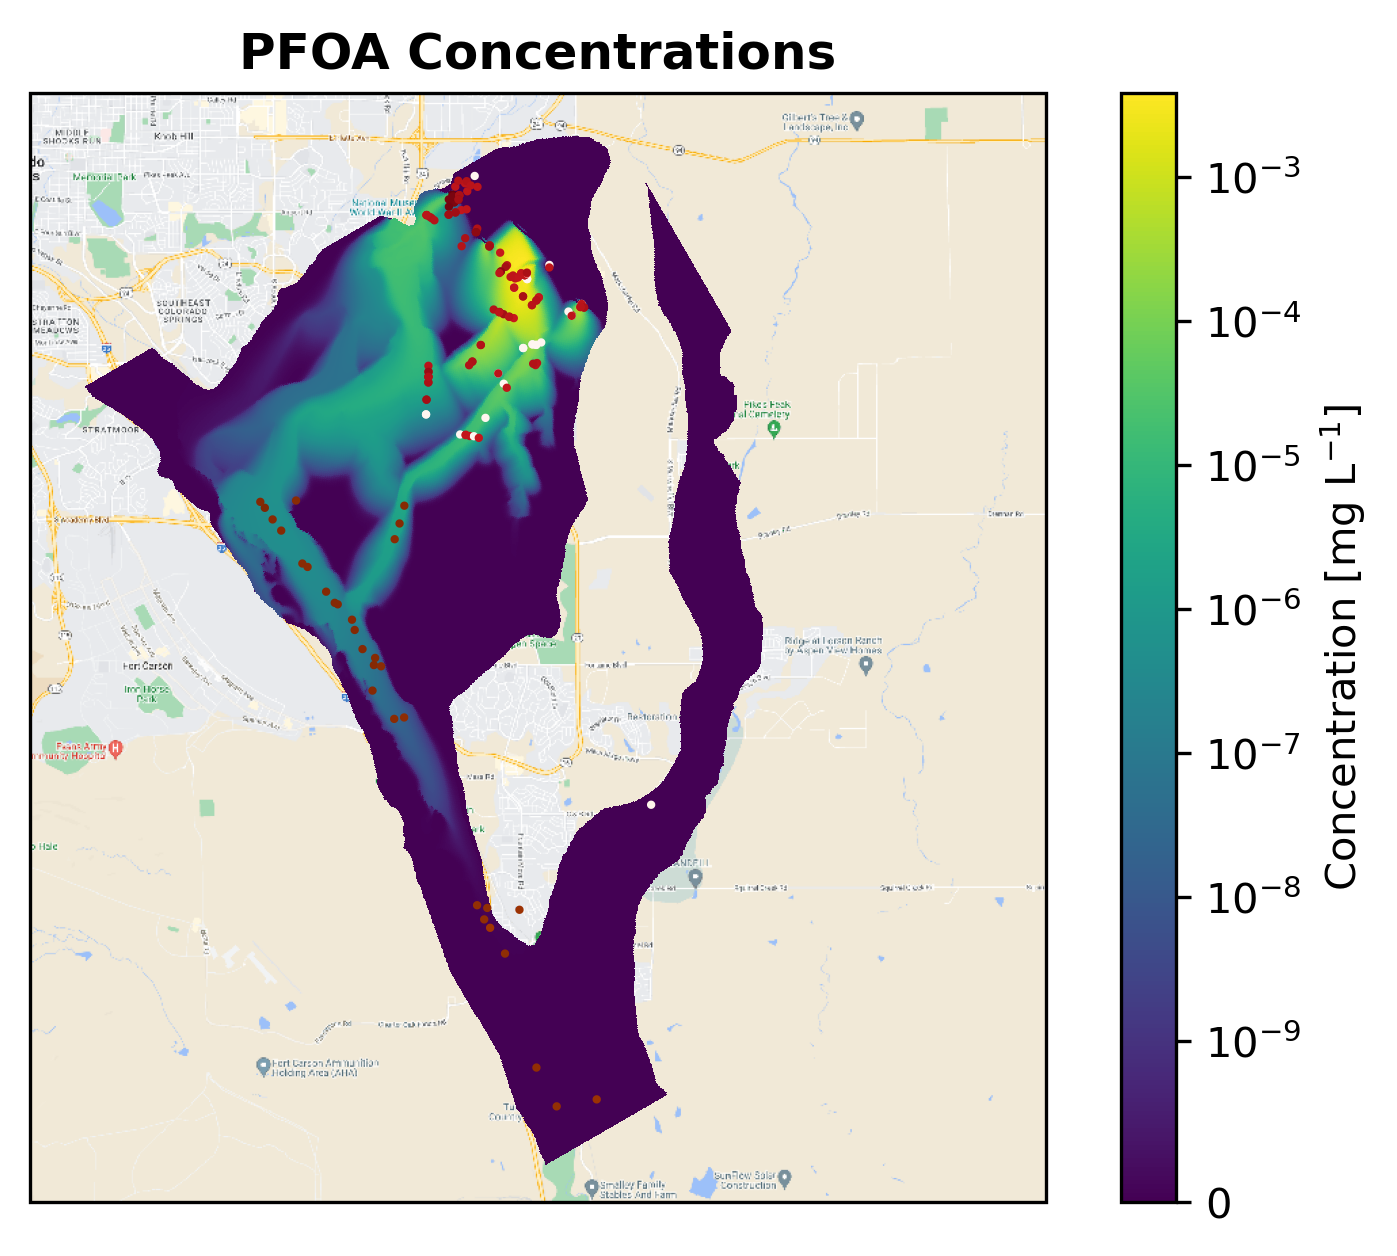

In [42]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, dpi=300)

modelmap = fplt.PlotMapView(model=gwt_pfoa)

vmax = pfos[pfos != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
cs1 = modelmap.plot_array(pfos, transform=ccrs.UTM(13), norm=norm)
fig.colorbar(cs1, ax=ax, label="Concentration [mg L$^{-1}$]")

# cs1 = modelmap.plot_array(k, transform=ccrs.UTM(13))
# fig.colorbar(cs1, ax=ax, label="Concentration [mg L$^{-1}$]")

ax.scatter(upstream_well['x'], upstream_well['y'], label=upstream_well['Well_ID'], transform=ccrs.PlateCarree(), c=upstream_well['Result_ngL'], s=1, cmap='Reds', norm=SymLogNorm(linthresh=1e-9, vmin=0))

ax.scatter(x, y, c=downstream_wells['PFOA (ng/L)'], transform=ccrs.UTM(13), cmap='Oranges', norm=SymLogNorm(linthresh=1e-9, vmin=0), s=1)


ggtiles = GoogleTiles()
ax.add_image(ggtiles, 13)
ax.set_title('PFOA Concentrations', weight='bold')

plt.show()

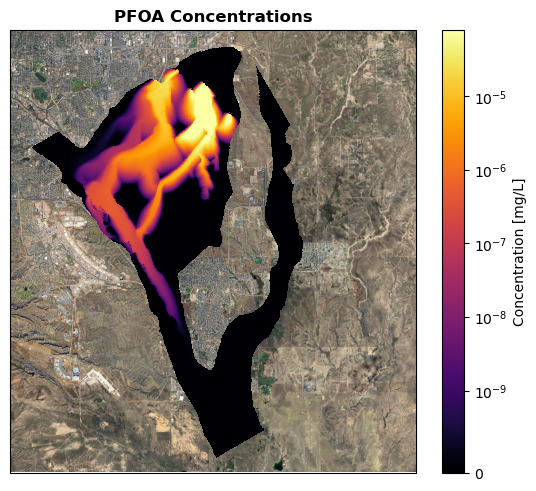

In [43]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained',)# figsize=(18, 5))

modelmap = fplt.PlotMapView(model=gwt_pfos)

# plot PFOA
vmax = PFOA[PFOA != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
conc = modelmap.plot_array(PFOS[-1], ax=ax, cmap='inferno', norm=norm,
                               transform=ccrs.UTM(13))
fig.colorbar(conc, ax=ax, label='Concentration [mg/L]')

ggtiles = GoogleTiles(style='satellite')
ax.add_image(ggtiles, 13)
ax.set_title('PFOA Concentrations', weight='bold')

plt.show()

### Observed vs Simulated PFOA concentration

In [44]:
# Read in simulated observations to a dataframe
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/pfoa_obs.csv', isBinary=False)
sim_wells = obs_out.get_dataframe()

closest_index = sim_wells.index[(np.abs(sim_wells.totim - 17713)).argmin()]
sim_results = sim_wells.loc[closest_index]

In [45]:
common_index = obs_wells.columns.intersection(sim_results.index)

sim_results = sim_results.loc[common_index] * 1e6
obs_results = obs_wells.T.loc[common_index, "PFOA (ng/L)"]

Text(0, 0.5, 'Simulated Concentration [ng L$^{-1}$]')

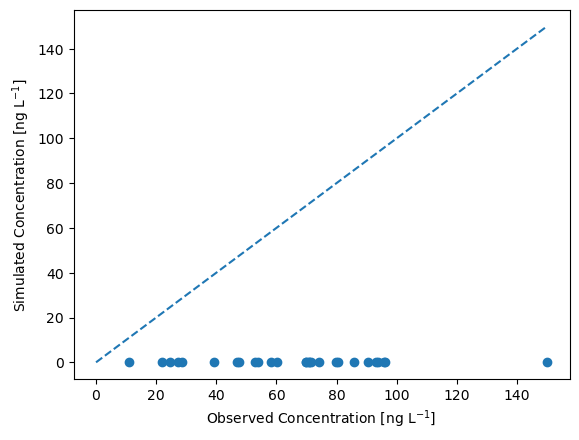

In [46]:
obs = obs_results.to_numpy(dtype='float64')
sim = sim_results.to_numpy(dtype='float64')

vmin = min(obs.min(), sim.min())
vmax = max(obs.max(), sim.max())
xy = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots()

ax.scatter(obs, sim)
ax.plot(xy, xy, linestyle='--')

ax.set_xlabel('Observed Concentration [ng L$^{-1}$]')
ax.set_ylabel('Simulated Concentration [ng L$^{-1}$]')

In [47]:
pfoa_us = pd.read_csv('../input-files/data-files/tran-PFOA-observations.csv')

In [48]:
pfoa_us['SDate'] = pd.to_datetime(pfoa_us.SDate)

In [49]:
pfoa_us.set_index('SDate', inplace=True)

In [50]:
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/pfoa_obs.csv', isBinary=False)
sim_wells = obs_out.get_dataframe()

In [51]:
# closest_index = sim_wells.index[(np.abs(sim_wells.totim - 17713)).argmin()]

closest_rows = []
for date in pfos_us.index:
    # Find the closest index in the reshaped DataFrame
    closest_index = sim_wells.index[(np.abs(sim_wells.index - date)).argmin()]
    
    # Store the closest date and row values
    closest_rows.append(closest_index)

In [52]:
sim_wells_aligned = sim_wells.loc[closest_rows]
sim_wells_aligned.drop(columns='totim', axis=1, inplace=True)

Well BRD_6 not in both
Well 11960_OPR_2 not in both
Well 12425_OPR_1 not in both
Well DLE not in both
Well GLD_3 not in both
Well ING_2 not in both
Well IRIS_3 not in both
Well WELL 1 not in both
Well WELL 3 not in both
Well WELL 4 not in both
Well FV4 not in both
Well R1 not in both
Well R2 not in both
Well S2 not in both
Well S4 not in both
Well S7 not in both
Well S9 not in both
Well S10 not in both
Well S11 not in both
Well S12 not in both
Well S13 not in both
Well S14 not in both
Well S15 not in both
Well S16 not in both
Well S17 not in both
Well W8 not in both
Well W9 not in both
Well W12 not in both
Well C2 not in both
Well C36 not in both
Well W7 not in both
Well DEICEPONDSNORTH not in both
Well DEICEPONDSNORTH_1 not in both
Well DEICEPONDSSOUTH not in both
Well MW1-2_1 not in both
Well MW2-1_1 not in both
Well MW2-2_1 not in both
Well MW2-3_1 not in both
Well MW2-3_2 not in both
Well MW2-3_3 not in both
Well MW2-4_1 not in both
Well MW2-4_2 not in both
Well MW4-1_1 not in both

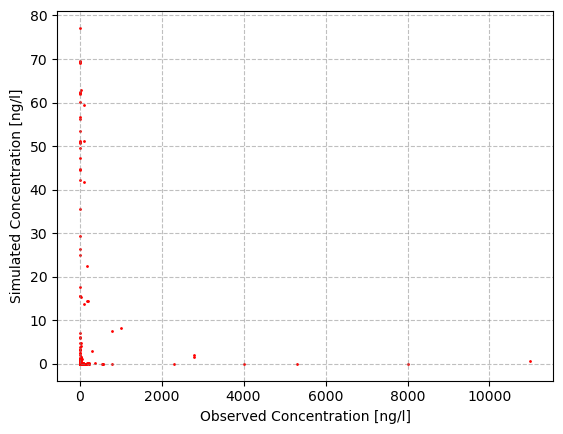

In [53]:
fig, ax = plt.subplots()

for col in sim_wells_aligned.columns:
    try:
        ax.scatter(pfoa_us[col], sim_wells_aligned[col] * 1e6, color='r', s=1)

    except:
        print(f"Well {col} not in both")

#ax.set_xscale('log')  # Log scale for the x-axis

ax.set_xlabel('Observed Concentration [ng/l]')
ax.set_ylabel('Simulated Concentration [ng/l]')
# ax.set_aspect('equal')
ax.grid(ls='--', color='gray', alpha=0.5)

### PFHxS Results

In [54]:
# Get solute concentrations
PFHxS = gwt_pfhxs.output.concentration().get_alldata()

In [55]:
PFHxS.shape

(446, 1, 972, 700)

In [56]:
pfhxs = gwt_pfhxs.output.concentration().get_data()

In [57]:
downstream_wells = pd.read_csv('../input-files/data-files/tran-targets-downstream.csv')
upstream_well = pd.read_excel('../input-files/data-files/tran-PFAS-targets.xlsx', sheet_name='PFHxS')

In [58]:
from matplotlib.colors import LogNorm

In [59]:
x = gwt_pfos.modelgrid.xcellcenters[downstream_wells['x'], downstream_wells['y']]
y = gwt_pfos.modelgrid.ycellcenters[downstream_wells['x'], downstream_wells['y']]

In [60]:
#upstream_well[upstream_well['Result_ngL'] == 0]

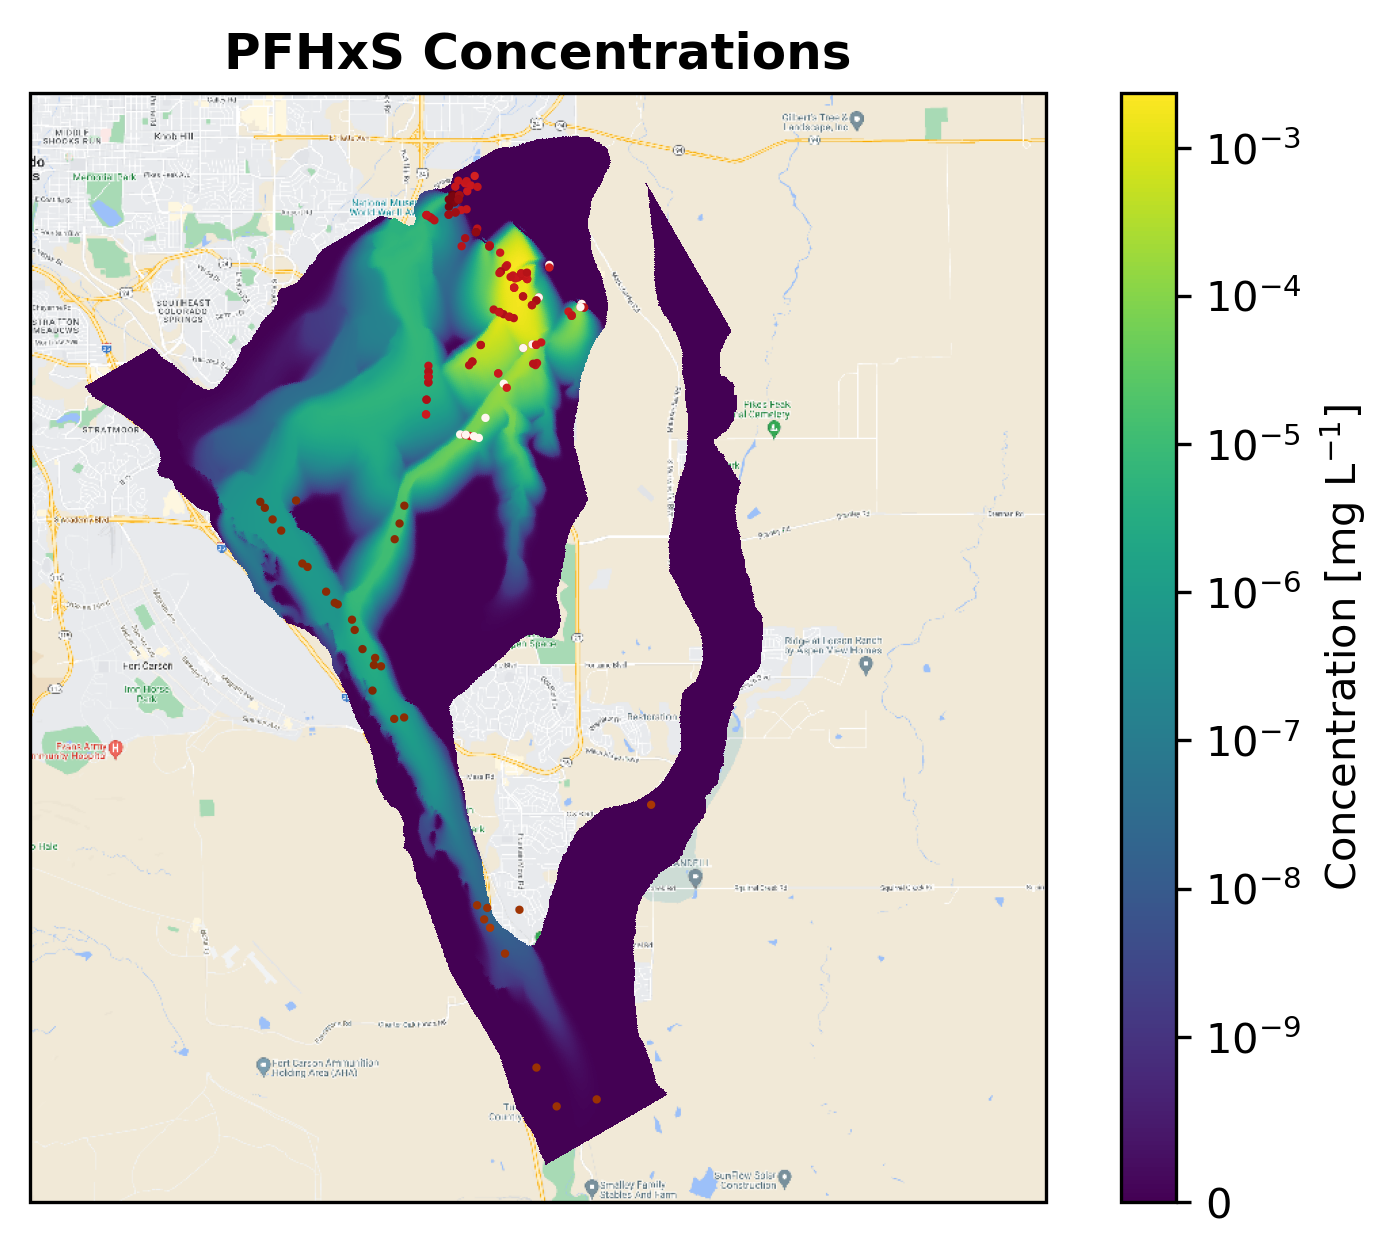

In [61]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, dpi=300)

modelmap = fplt.PlotMapView(model=gwt_pfos)

vmax = pfhxs[pfhxs != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
cs1 = modelmap.plot_array(pfhxs, transform=ccrs.UTM(13), norm=norm)
fig.colorbar(cs1, ax=ax, label="Concentration [mg L$^{-1}$]")

# cs1 = modelmap.plot_array(k, transform=ccrs.UTM(13))
# fig.colorbar(cs1, ax=ax, label="Concentration [mg L$^{-1}$]")

ax.scatter(upstream_well['x'], upstream_well['y'], label=upstream_well['Well_ID'], transform=ccrs.PlateCarree(), c=upstream_well['Result_ngL'], s=1, cmap='Reds', norm=SymLogNorm(linthresh=1e-9, vmin=0))

ax.scatter(x, y, c=downstream_wells['PFHxS (ng/L)'], transform=ccrs.UTM(13), cmap='Oranges', norm=SymLogNorm(linthresh=1e-9, vmin=0), s=1)


ggtiles = GoogleTiles()
ax.add_image(ggtiles, 13)
ax.set_title('PFHxS Concentrations', weight='bold')

plt.show()

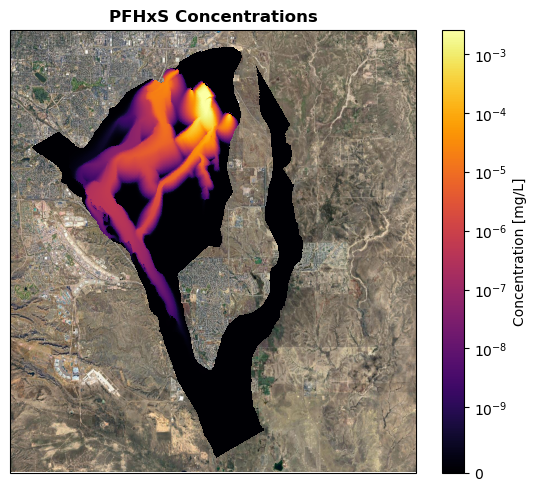

In [62]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained',)# figsize=(18, 5))

modelmap = fplt.PlotMapView(model=gwt_pfos)

# plot PFOS
vmax = PFHxS[PFHxS != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
conc = modelmap.plot_array(PFOS[-1], ax=ax, cmap='inferno', norm=norm,
                               transform=ccrs.UTM(13))
fig.colorbar(conc, ax=ax, label='Concentration [mg/L]')

ggtiles = GoogleTiles(style='satellite')
ax.add_image(ggtiles, 13)
ax.set_title('PFHxS Concentrations', weight='bold')

plt.show()

### Observed vs Simulated PFHxS concentration

In [63]:
# Read in simulated observations to a dataframe
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/pfhxs_obs.csv', isBinary=False)
sim_wells = obs_out.get_dataframe()

closest_index = sim_wells.index[(np.abs(sim_wells.totim - 17713)).argmin()]
sim_results = sim_wells.loc[closest_index]

In [64]:
common_index = obs_wells.columns.intersection(sim_results.index)

sim_results = sim_results.loc[common_index] * 1e6
obs_results = obs_wells.T.loc[common_index, "PFHxS (ng/L)"]

Text(0, 0.5, 'Simulated Concentration [ng L$^{-1}$]')

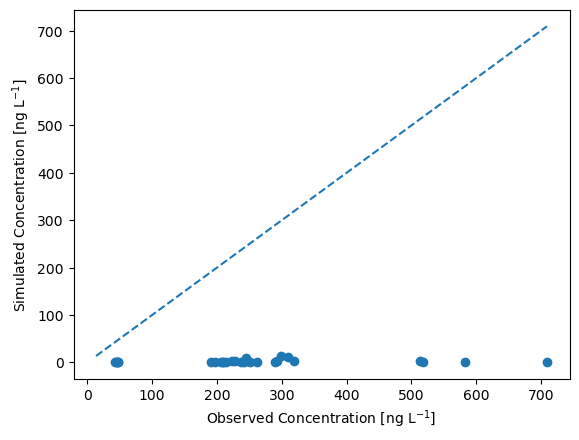

In [65]:
obs = obs_results.to_numpy(dtype='float64')
sim = sim_results.to_numpy(dtype='float64')

vmin = min(obs.min(), sim.min())
vmax = max(obs.max(), sim.max())
xy = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots()

ax.scatter(obs, sim)
ax.plot(xy, xy, linestyle='--')

ax.set_xlabel('Observed Concentration [ng L$^{-1}$]')
ax.set_ylabel('Simulated Concentration [ng L$^{-1}$]')

In [66]:
pfhxs_us = pd.read_csv('../input-files/data-files/tran-PFHxS-observations.csv')

In [67]:
pfhxs_us['SDate'] = pd.to_datetime(pfhxs_us.SDate)

In [68]:
pfhxs_us.set_index('SDate', inplace=True)

In [69]:
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/pfhxs_obs.csv', isBinary=False)
sim_wells = obs_out.get_dataframe()

In [70]:
# closest_index = sim_wells.index[(np.abs(sim_wells.totim - 17713)).argmin()]

closest_rows = []
for date in pfos_us.index:
    # Find the closest index in the reshaped DataFrame
    closest_index = sim_wells.index[(np.abs(sim_wells.index - date)).argmin()]
    
    # Store the closest date and row values
    closest_rows.append(closest_index)

In [71]:
sim_wells_aligned = sim_wells.loc[closest_rows]
sim_wells_aligned.drop(columns='totim', axis=1, inplace=True)

Well BRD_6 not in both
Well 11960_OPR_2 not in both
Well 12425_OPR_1 not in both
Well DLE not in both
Well GLD_3 not in both
Well ING_2 not in both
Well IRIS_3 not in both
Well WELL 1 not in both
Well WELL 3 not in both
Well WELL 4 not in both
Well FV4 not in both
Well R1 not in both
Well R2 not in both
Well S2 not in both
Well S4 not in both
Well S7 not in both
Well S9 not in both
Well S10 not in both
Well S11 not in both
Well S12 not in both
Well S13 not in both
Well S14 not in both
Well S15 not in both
Well S16 not in both
Well S17 not in both
Well W8 not in both
Well W9 not in both
Well W12 not in both
Well C2 not in both
Well C36 not in both
Well W7 not in both
Well DEICEPONDSNORTH not in both
Well DEICEPONDSNORTH_1 not in both
Well DEICEPONDSSOUTH not in both
Well MW1-2_1 not in both
Well MW2-1_1 not in both
Well MW2-2_1 not in both
Well MW2-3_1 not in both
Well MW2-3_2 not in both
Well MW2-3_3 not in both
Well MW2-4_1 not in both
Well MW2-4_2 not in both
Well MW4-1_1 not in both

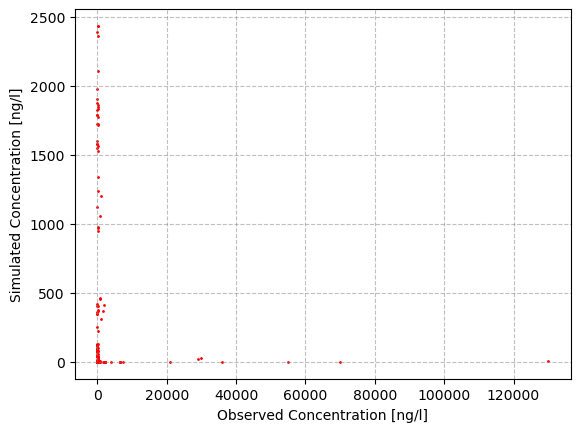

In [72]:
fig, ax = plt.subplots()

for col in sim_wells_aligned.columns:
    try:
        ax.scatter(pfhxs_us[col], sim_wells_aligned[col] * 1e6, color='r', s=1)

    except:
        print(f"Well {col} not in both")

#ax.set_xscale('log')  # Log scale for the x-axis

ax.set_xlabel('Observed Concentration [ng/l]')
ax.set_ylabel('Simulated Concentration [ng/l]')
# ax.set_aspect('equal')
ax.grid(ls='--', color='gray', alpha=0.5)

In [73]:
import imageio

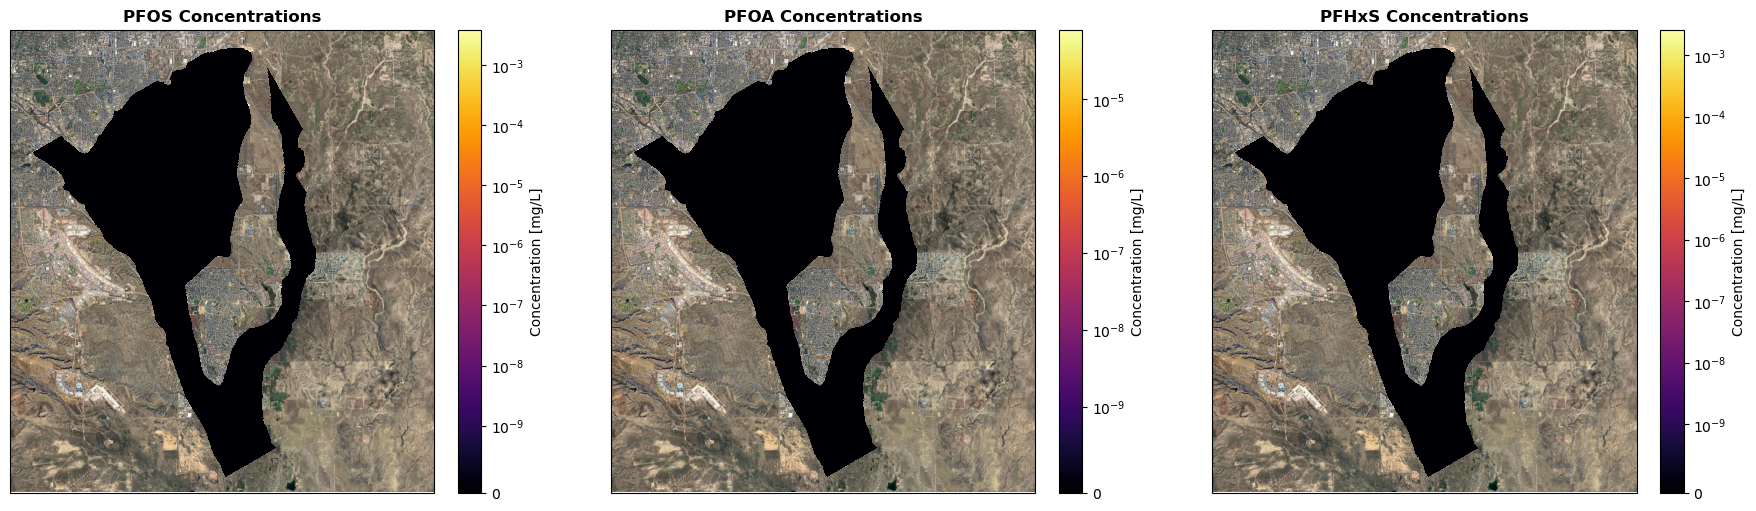

In [74]:
fig, axs = plt.subplots(ncols=3, subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained', figsize=(18, 5))
ax1, ax2, ax3 = axs

modelmap = fplt.PlotMapView(model=gwt_pfos)

# plot PFOS
vmax = PFOS[PFOS != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
cellhead = modelmap.plot_array(PFOS[0], ax=ax1, cmap='inferno', norm=norm,
                               transform=ccrs.UTM(13))
fig.colorbar(cellhead, ax=ax1, label='Concentration [mg/L]')

# Plot PFOA
vmax = PFOA[PFOA != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
cellhead = modelmap.plot_array(PFOA[0], ax=ax2, cmap='inferno', norm=norm, 
                               transform=ccrs.UTM(13))
fig.colorbar(cellhead, ax=ax2, label='Concentration [mg/L]')

# Plot PFHxS
vmax = PFHxS[PFHxS != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
cellhead = modelmap.plot_array(PFHxS[0], ax=ax3, cmap='inferno', norm=norm, 
                               transform=ccrs.UTM(13))
fig.colorbar(cellhead, ax=ax3, label='Concentration [mg/L]')

titles = ['PFOS Concentrations', 'PFOA Concentrations', 'PFHxS Concentrations']
for ax, title in zip(axs, titles):
    ggtiles = GoogleTiles(style='satellite')
    ax.add_image(ggtiles, 13)
    
    ax.set_title(title, weight='bold')

plt.show()

In [75]:
# for i in range(350):
#     fig, axs = plt.subplots(ncols=3, subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained', figsize=(18, 5))
#     ax1, ax2, ax3 = axs
    
#     modelmap = fplt.PlotMapView(model=gwt_pfos)
    
#     # plot PFOS
#     vmax = PFOS[PFOS != 1e30].max()
#     norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
#     cellhead = modelmap.plot_array(PFOS[i][0], ax=ax1, cmap='inferno', norm=norm,
#                                    transform=ccrs.UTM(13))
#     fig.colorbar(cellhead, ax=ax1, label='Concentration [mg/L]')
    
#     # Plot PFOA
#     vmax = PFOA[PFOA != 1e30].max()
#     norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
#     cellhead = modelmap.plot_array(PFOA[i][0], ax=ax2, cmap='inferno', norm=norm, 
#                                    transform=ccrs.UTM(13))
#     fig.colorbar(cellhead, ax=ax2, label='Concentration [mg/L]')
    
#     # Plot PFHxS
#     vmax = PFHxS[PFHxS != 1e30].max()
#     norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
#     cellhead = modelmap.plot_array(PFHxS[i][0], ax=ax3, cmap='inferno', norm=norm, 
#                                    transform=ccrs.UTM(13))
#     fig.colorbar(cellhead, ax=ax3, label='Concentration [mg/L]')
    
#     titles = ['PFOS Concentrations', 'PFOA Concentrations', 'PFHxS Concentrations']
#     for ax, title in zip(axs, titles):
#         ggtiles = GoogleTiles(style='satellite')
#         ax.add_image(ggtiles, 13)
        
#         ax.set_title(title, weight='bold')
    
#     plt.savefig(f'../figures/gif-pngs/sp-{i}.png')
#     plt.close()

# pngs = [imageio.v2.imread(f'../figures/gif-pngs/sp-{i}.png') for i in range(350)]

# imageio.mimsave('../figures/concentrations.gif', pngs, duration=50, loop=0)